In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import xgboost as xgb

from scipy.stats import boxcox

import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from wordcloud import WordCloud

from joblib import dump, load
import pickle

import string
import re
import time

# pip install pandas-profiling
# from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import the dataset
data = pd.read_csv("C:/Users/awsbd/Desktop/Sentiment/archive/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data.columns = ['sentiment', 'time', 'date', 'query', 'username', 'comment']
data.head()

,sentiment,time,date,query,username,comment
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
# checking the shape of the dataframe
data.shape

(1599999, 6)

In [6]:
#checking the datatype, number of null values present
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   time       1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   query      1599999 non-null  object
 4   username   1599999 non-null  object
 5   comment    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
# checking the column wise to check for the presence of null values
data.isnull().sum()

sentiment    0
time         0
date         0
query        0
username     0
comment      0
dtype: int64

In [8]:
# checking the spread of values in the target variable
data['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

<Axes: >

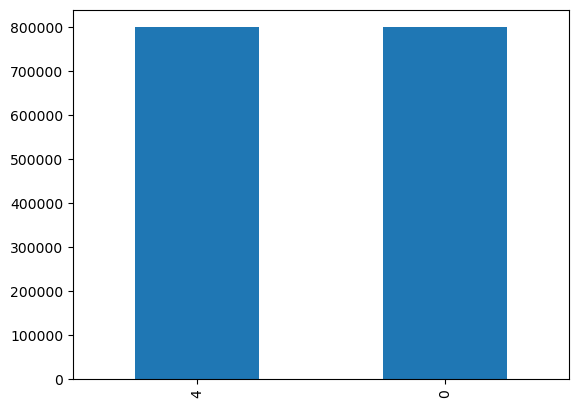

In [9]:
# checking the sum in bar chart
data['sentiment'].value_counts().plot.bar()

In [10]:
# considering the relevant columns in the final dataframe
data = data [['comment', 'sentiment']]
data.head()

,comment,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [11]:
# converting the positive sentiment value '4' to '1' in the target variable for better understanding
data['sentiment'] = data['sentiment'].apply(lambda x : 1 if x == 4 else x)

In [12]:
# checking the spread of values post change
data['sentiment'].value_counts()

1    800000
0    799999
Name: sentiment, dtype: int64

In [13]:
# check dataset 
data.head()

,comment,sentiment
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [14]:
comment, sentiment = list(data['comment']), list(data['sentiment'])

# Data PreProcessing

In [17]:
# stop = stopwords.words('english')

In [37]:
# defined a method with all preprocessing functions

def preprocessing(commentdata):
    
    # Defining dictionary containing all emojis with their meanings
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ';-E': "vampire", ':(': 'sad',
             ':-(': 'sad', '<-(': 'sad', ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked',
             ':@': 'shocked', ':-$': 'confused', ':\\': 'annoyed', ':#': 'mute', ':X': 'mute', ':^)': 'smile',
             ':-&': 'confused', '$_$': 'greedy', '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile',
             ':-0': 'yell', 'O.o': 'confused', '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ':-)': 'sadsmile',
             ';)': 'wink', ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:D': 'gossip',
             'm^.m^': 'cat'}
    
    stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an'
                   'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being',
                   'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few',
                   'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself',
                   'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more',
                   'most', 'my', 'myself', 'now', 'o', 'of', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
                   'out', 'own', 're', 's', 'same', 'she', 'shes', 'should', 'shouldve', 'so', 'some', 'such', 't', 'than', 'that',
                   'thatll', 'the', 'their', 'theirs', 'them', 'themeselves', 'then', 'there', 'these', 'they', 'this', 'those', 
                   'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 
                   'while', 'who', 'whom', 'why', 'will', 'with', 'won', 'y', 'you', 'youd', 'youll', 'youre', 'youve', 'your', 'yours', 'yourself', 'yourselves',]
    
    processedComment = []
    
    # Defining regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ])"
    userPattern = '@[^\s]+'
    
    # alphapattern = "[^a-zA-Z0-9]"
    alphaPattern = "[^a-zA-Z]"
    sequencePattern = r"(.)\1\1+"
    sequenceReplacePattern = r"\1\1"
    
    for tweet in commentdata:
        tweet = tweet.lower()
        
        #replcae all URLs with 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        
        # Replace all emojir
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        
        # Replace @USERNAME to 'USER'
        tweet = re.sub(userPattern, 'USER', tweet)
        
        # Replace all non alphabets
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replacing sequential pattern
        tweet = re.sub(sequencePattern, sequenceReplacePattern, tweet)
        
        # Removing punctuations if any left post removing all non alphabets
        all_char_list = []
        all_char_list = [char for char in tweet if char not in string.punctuation]
        tweet = ''.join(all_char_list)
        
        # Removing all stopwords as per custom list defined above
        tweetwords = ''
        
        for word in tweet.split():
            if word not in (stopwordlist):
                if len(word)>1:
                    tweetwords += (word+' ')
                    
        processedComment.append(tweetwords)
    
    return processedComment

In [40]:
# Applying the entire comment stored in list "comment" for preprocessing and calculating the time taken to perform the operation
t = time.time()
preprocessedComment = preprocessing(comment)
print('Comment processing complete.')
print(f'Time taken: {round(time.time()-t)} seconds')

Comment processing complete.
Time taken: 139 seconds


In [42]:
# Defining a method to return the 2nd parameter for Lemmatization the is "Parts of Speech(POS)" tag
def get_wordnet_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [53]:
# Created a method to perform lemmatization with POS tags identified via a pos_tag method
def lemmatize_process(preprocessedComment):
    # create lemmatizer
    lemma = WordNetLemmatizer()
    
    finalprocessedComment = []
    for tweet in preprocessedComment:
        text_pos = pos_tag(word_tokenize(tweet))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        tweet_lemma = " ".join([lemma.lemmatize(a, get_wordnet_pos_tag(b)) for a,b in zip(words, pos)])
        finalprocessedComment.append(tweet_lemma)
    return finalprocessedComment

In [58]:
# Applying the entire list stored in list "comment" for preprocessing and calculating the time taken to perform the operation
t = time.time()
processedcomment = lemmatize_process(preprocessedComment)
print('Comment lemmatization complete.')
print(f'Time taken: {round(time.time()-t)} seconds')

Comment lemmatization complete.
Time taken: 2667 seconds


# Data Analysis

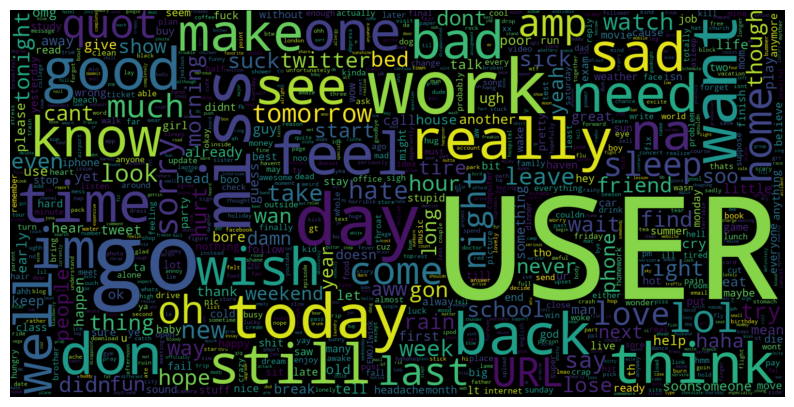

In [74]:
# Creating word cloud of negative twwets,  where the words appearing larger are more frequent in nature accross articles
# First 8000000 tweets in the list negative tweets

data_neg = processedcomment[:800000]
all_negwords = ' '.join(data_neg)
wordcloud = WordCloud(max_words = 1000, width = 1600, height = 800,
                       collocations = False).generate(all_negwords)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

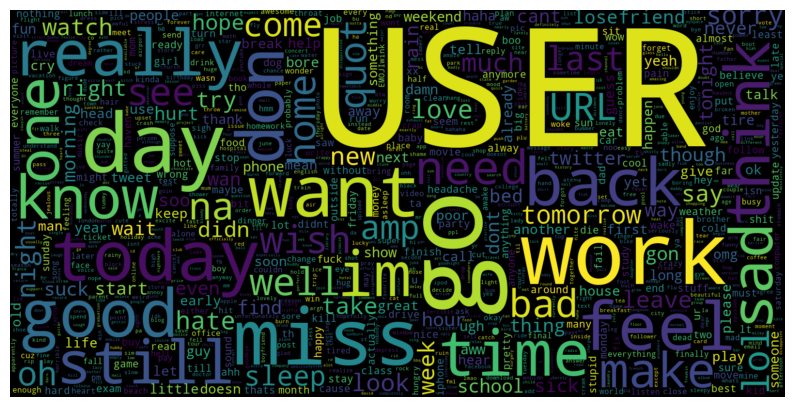

In [76]:
# Creating word cloud of positive twwets, where the words appearing larger are more frequent in nature accross articles
# Last 8000000 tweets in the list are positive tweets

data_pos = processedcomment[800000:]
all_poswords = ' '.join(data_pos)
wordcloud = WordCloud(max_words = 1000, width = 1600, height = 800,
                      collocations = False).generate(all_negwords)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [66]:
# Created a method using WhitespaceTokenizer and FreqDist to identify the mos frequent set of words in the dataset segregated
# by target variable

token_wspace = tokenize.WhitespaceTokenizer()

def mostFrequentWords(tweets, quantity):
    all_words = ' '.join(tweets)
    all_tokens = token_wspace.tokenize(all_words)
    freq_dist = nltk.FreqDist(all_tokens)
    df_frequency = pd.DataFrame({"Word": list(freq_dist.keys()), "Frequency": list(freq_dist.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = 'Word', y = 'Frequency', color = 'blue')
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 'vertical')
    plt.show()

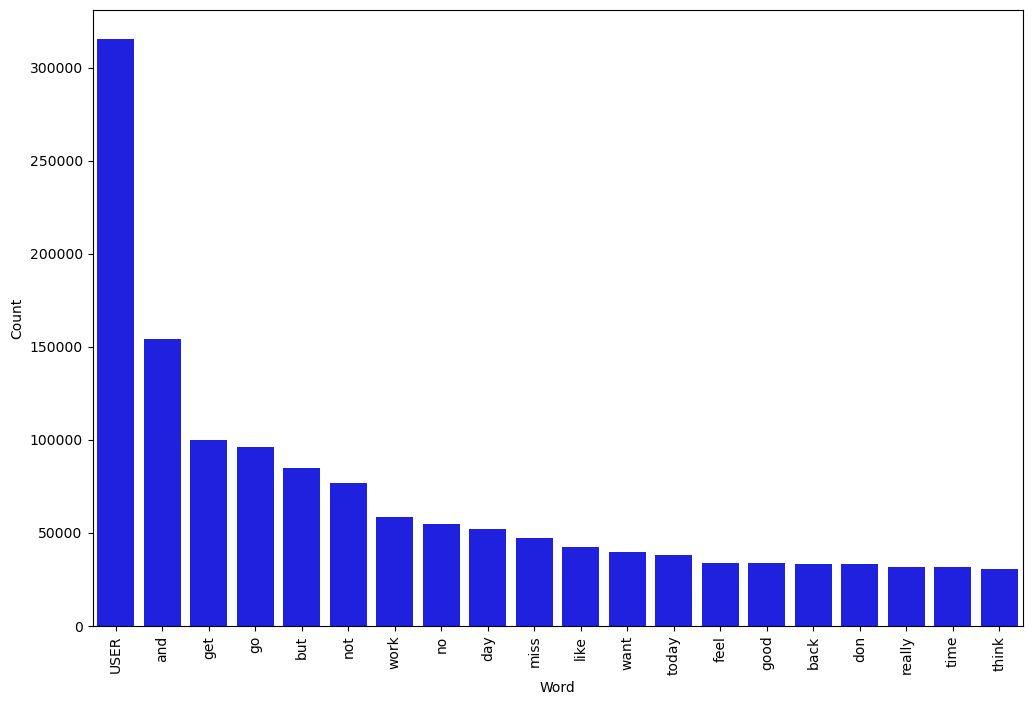

In [73]:
# calling the above method for negative cases, plotting the most frequent top 10 words
mostFrequentWords(processedcomment[:800000],20)

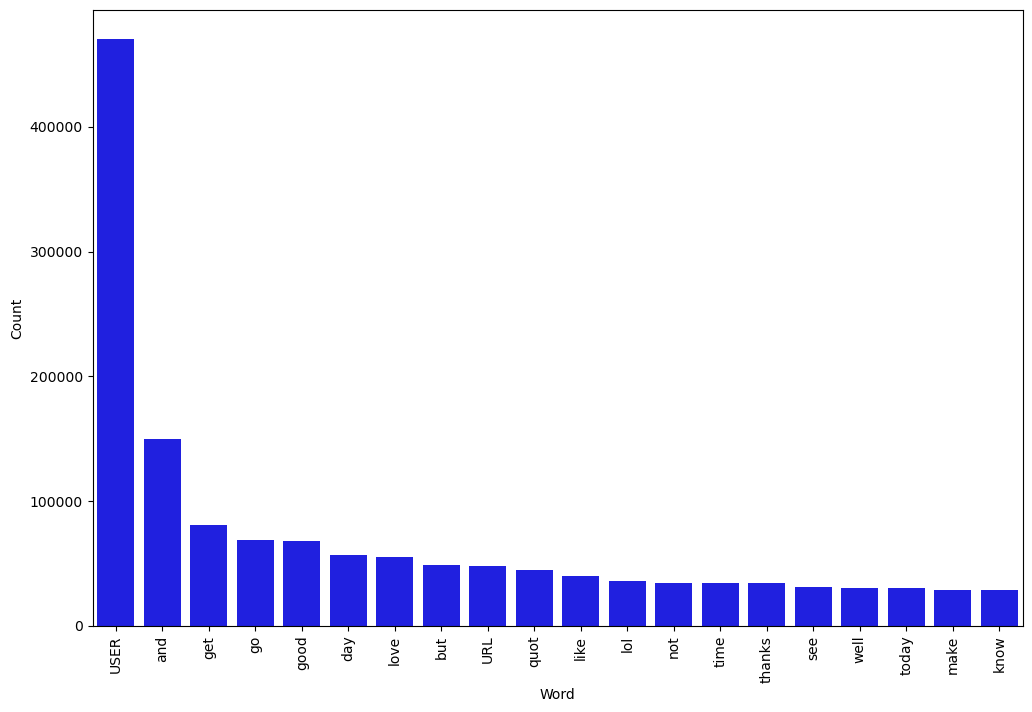

In [72]:
mostFrequentWords(processedcomment[800000:],20)

# Splitting the Data

In [85]:
# Splitting the entire set into train and test with test size of 5%
X_train, X_test, y_train, y_test = train_test_split(processedcomment, sentiment,
                                                   test_size = 0.05, random_state = 0)
print('Data Split done...')

Data Split done...


# TF-IDF Vectoriser

TF-IDF indicates the importance of a word, in order to
understand the document or dataset. Let us understand with an
example. Suppose you have a dataset where students write an
essay on the topic, My Bike. In this dataset, the bike word appears
many times; it's a high frequency word compared to other words in
the dataset. The dataset contains other words like street, long ride,
helmets and so on that appear less often, so their frequency are
lower and they carry more information compared to the word. This
is the intuition behind TF-IDF.

TF-IDF Vectoriser converts a collection of raw documents to
a matrix of TF-IDF features. The Vectoriser is usually trained on
only the train dataset.

ngram_range is the range of number of words in a sequence. [e.g
“very expensive” is a 2-gram that is considered as an extra feature
separately from "very" and "expensive" when you have a n-gram
range of (1,2)]

max _features specifies the number of features to
consider. [Ordered by feature frequency across the corpus].

In [90]:
# Fitting TFIDF vectoriser on the train dataset
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features = 500000)
vectoriser.fit(X_train)
print('Vectoriser fitted...')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted...
No. of feature_words:  500000


# Transforming Dataset

In [91]:
# Transforming the X_train and X_test dataset on the fitted model
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print('Data Transformed..')

Data Transformed..


# Confusion Matics

A confusion matrix is a table that is often used to describe
the performance of a classification model (or "classifier")
on a set of test data for which the true values are known.

True Positives => Observation is Positive, and the model
classified it as Positive

True Negatives => Observation is Negative, and the model
classified it as Negative

False Negatives => Observation is Positive, but the model
classified it as Negative

False Positives => Observation is Negative, but the model
classified it as Positive

In [ ]:
Classifica